In [108]:
import requests
import pandas as pd

## Endpoints

In [109]:
LEAGUE_ID = 85647
PAGE_ID = 1
GW = 10
PLAYER_ID = 18103
PAGE_COUNT = 1

gw_url = "https://fantasy.premierleague.com/api/event/{}/live/"  # stands for gameweek
fixture_url = "https://fantasy.premierleague.com/api/fixtures/"  # FIXTURE_ID
transfer_url = "https://fantasy.premierleague.com/api/entry/{}/transfers/"  # player_id
history_url = (
    "https://fantasy.premierleague.com/api/entry/{}/history/"  # {} = PLAYER_ID
)
h2h_league = (
    "https://fantasy.premierleague.com/api/leagues-h2h-matches/league/{}/"  # LEAGUE_ID
)

# You can access members of your leagues with this code
league_url = "https://fantasy.premierleague.com/api/leagues-classic/{}/standings/?page_standings={}"
# ?page_new_entries=1&page_standings={page_id}&phase=2"

# with the main api, You can access players, teams, fixtures, phases of the game. Use json.keys() to Dictionary of elements
FPL_url = "https://fantasy.premierleague.com/api/bootstrap-static/"

# Access Entry picks with the team_id
fpl_player = "https://fantasy.premierleague.com/api/entry/{}/event/{}/picks/"  # corresponds to player_id and gameweek

In [110]:
pd.set_option("display.max_columns", 80)

In [111]:
home = requests.get(FPL_url)
home = home.json()
print(home.keys())

dict_keys(['events', 'game_settings', 'phases', 'teams', 'total_players', 'elements', 'element_stats', 'element_types'])


In [ ]:
home["teams"]

In [113]:
team_code_to_name = {item["code"]: item["name"] for item in home["teams"]}
team_id_to_name = {item["id"]: item["name"] for item in home["teams"]}
pos_code_to_pos = {item["id"]: item["singular_name"] for item in home["element_types"]}

pos_code_to_pos

{1: 'Goalkeeper', 2: 'Defender', 3: 'Midfielder', 4: 'Forward'}

In [ ]:
epl_player_info = [
    (
        item["id"],
        pos_code_to_pos[item["element_type"]],
        team_code_to_name[item["team_code"]],
        item["first_name"] + " " + item["second_name"],
    )
    for item in home["elements"]
]

player_df = pd.DataFrame(
    epl_player_info, columns=["player_id", "position", "team", "player_name"]
)
player_df

GAMEWEEK URL

In [115]:
mapping = player_df[["player_id", "team", "position"]].to_dict("list")

player_team_mapping = {i: j for i, j in zip(mapping["player_id"], mapping["team"])}
player_position_mapping = {
    i: j for i, j in zip(mapping["player_id"], mapping["position"])
}

In [116]:
gw_url = "https://fantasy.premierleague.com/api/event/{}/live/"  # stands for gameweek

In [117]:
dfs = []
for i in range(1, 10):
    home = requests.get(gw_url.format(i))
    home = home.json()
    temp_df = pd.DataFrame(home["elements"])

    # manual way
    # interest_keys = list(temp_df['stats'][1].keys())
    # for key in interest_keys:
    #     temp_df[key] = temp_df['stats'].map(lambda x:x[key])

    # better way
    stats_df = pd.json_normalize(temp_df["stats"])
    temp_df["fixtures"] = temp_df["explain"].map(lambda x: x[0]["fixture"])
    temp_df.drop(["stats", "explain"], axis=1, inplace=True)

    dfs.append(pd.concat([temp_df, stats_df], axis=1))
    dfs

In [118]:
full_df = pd.concat(dfs, axis=0)
full_df["team"] = full_df["id"].map(lambda x: player_team_mapping[x])
full_df["position"] = full_df["id"].map(lambda x: player_position_mapping[x])

In [119]:
full_df.head(10)

,id,fixtures,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,starts,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,total_points,in_dreamteam,team,position
0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0.00,0.00,0.00,0.00,0,False,Arsenal,Midfielder
1,2,2,5,0,0,0,0,0,0,0,1,0,0,0,1,0.2,0.8,0.0,0.1,0,0.00,0.00,0.00,0.15,0,False,Arsenal,Forward
2,3,2,90,0,0,1,0,0,0,0,0,0,0,0,22,13.8,1.4,8.0,2.3,1,0.12,0.02,0.14,0.47,6,False,Arsenal,Defender
3,4,2,90,1,1,1,0,0,0,0,0,0,0,3,48,54.8,24.1,46.0,12.5,1,0.45,0.04,0.49,0.47,12,True,Arsenal,Forward
4,5,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0.00,0.00,0.00,0.00,0,False,Arsenal,Goalkeeper
5,6,2,21,0,0,0,0,0,0,0,0,0,0,0,2,0.0,0.8,8.0,0.8,0,0.02,0.01,0.03,0.15,1,False,Arsenal,Defender
6,7,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0.00,0.00,0.00,0.00,0,False,Arsenal,Midfielder
7,8,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0.00,0.00,0.00,0.00,0,False,Arsenal,Defender
8,9,2,90,0,0,1,0,0,0,0,0,0,0,0,16,13.6,36.7,25.0,7.5,1,0.08,0.19,0.27,0.47,3,False,Arsenal,Midfielder
9,10,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0.00,0.00,0.00,0.00,0,False,Fulham,Midfielder


In [120]:
full_df["fixtures"].unique()

array([ 2,  1,  7,  5,  6, 10,  8,  3,  9,  4, 11, 15, 18, 12, 19, 16, 13,
       20, 14, 17, 21, 25, 23, 22, 29, 26, 24, 28, 27, 30, 39, 35, 34, 38,
       36, 31, 32, 37, 33, 40, 47, 44, 43, 48, 42, 41, 46, 49, 45, 50, 51,
       59, 55, 52, 56, 57, 53, 54, 60, 58, 61, 69, 66, 65, 62, 68, 64, 63,
       67, 70, 71, 72, 77, 78, 79, 75, 76, 74, 73, 80, 81, 87, 86, 89, 88,
       82, 83, 84, 85, 90])

In [121]:
fix = requests.get(fixture_url)
fix = fix.json()
fixture_df = pd.DataFrame(fix)

fixture_df = fixture_df.rename(
    {
        "event": "gameweek",
        "team_h_difficulty": "homedifficulty",
        "team_a_difficulty": "awaydifficulty",
        "team_h": "home",
        "team_a": "away",
        "team_h_score": "homegoals",
        "team_a_score": "awaygoals",
        "kickoff_time": "date",
    },
    axis=1,
)
# pd.set_option()
fixture_df = fixture_df[
    [
        "homedifficulty",
        "awaydifficulty",
        "home",
        "away",
        "homegoals",
        "awaygoals",
        "code",
        "gameweek",
        "finished",
        "date",
    ]
]

fixture_df["home"] = fixture_df["home"].map(lambda x: team_id_to_name[x])
fixture_df["away"] = fixture_df["away"].map(
    lambda x: team_id_to_name[x]
)  # different from full_df

fixture_df["code"] = (
    fixture_df["code"].astype(int).map(lambda x: x - 2444470)
)  # to match full_df
fixture_df.rename({"code": "fixtures"}, axis=1, inplace=True)

fixture_df.head(10)

,homedifficulty,awaydifficulty,home,away,homegoals,awaygoals,fixtures,gameweek,finished,date
0,2,3,Man Utd,Fulham,1.0,0.0,0,1,True,2024-08-16T19:00:00Z
1,5,2,Ipswich,Liverpool,0.0,2.0,3,1,True,2024-08-17T11:30:00Z
2,2,5,Arsenal,Wolves,2.0,0.0,1,1,True,2024-08-17T14:00:00Z
3,2,2,Everton,Brighton,0.0,3.0,2,1,True,2024-08-17T14:00:00Z
4,2,4,Newcastle,Southampton,1.0,0.0,4,1,True,2024-08-17T14:00:00Z
5,2,2,Nott'm Forest,Bournemouth,1.0,1.0,5,1,True,2024-08-17T14:00:00Z
6,3,2,West Ham,Aston Villa,1.0,2.0,6,1,True,2024-08-17T16:30:00Z
7,2,3,Brentford,Crystal Palace,2.0,1.0,7,1,True,2024-08-18T13:00:00Z
8,5,4,Chelsea,Man City,0.0,2.0,8,1,True,2024-08-18T15:30:00Z
9,4,2,Leicester,Spurs,1.0,1.0,9,1,True,2024-08-19T19:00:00Z


In [100]:
fixture_df.columns

Index(['homedifficulty', 'awaydifficulty', 'home', 'away', 'homegoals',
       'awaygoals', 'fixtures', 'gameweek', 'finished', 'date'],
      dtype='object')

In [131]:
fixture_df["homewin"] = fixture_df["homegoals"] > fixture_df["awaygoals"]
fixture_df["draw"] = fixture_df["homegoals"] == fixture_df["awaygoals"]
fixture_df["awaywin"] = fixture_df["homegoals"] < fixture_df["awaygoals"]

fixture_df["homewin"] = fixture_df["homewin"].astype(int)
fixture_df["draw"] = fixture_df["draw"].astype(int)
fixture_df["awaywin"] = fixture_df["awaywin"].astype(int)

fixture_df.head(10)

,homedifficulty,awaydifficulty,home,away,homegoals,awaygoals,fixtures,gameweek,finished,date,homewin,draw,awaywin
0,2,3,Man Utd,Fulham,1.0,0.0,0,1,True,2024-08-16T19:00:00Z,1,0,0
1,5,2,Ipswich,Liverpool,0.0,2.0,3,1,True,2024-08-17T11:30:00Z,0,0,1
2,2,5,Arsenal,Wolves,2.0,0.0,1,1,True,2024-08-17T14:00:00Z,1,0,0
3,2,2,Everton,Brighton,0.0,3.0,2,1,True,2024-08-17T14:00:00Z,0,0,1
4,2,4,Newcastle,Southampton,1.0,0.0,4,1,True,2024-08-17T14:00:00Z,1,0,0
5,2,2,Nott'm Forest,Bournemouth,1.0,1.0,5,1,True,2024-08-17T14:00:00Z,0,1,0
6,3,2,West Ham,Aston Villa,1.0,2.0,6,1,True,2024-08-17T16:30:00Z,0,0,1
7,2,3,Brentford,Crystal Palace,2.0,1.0,7,1,True,2024-08-18T13:00:00Z,1,0,0
8,5,4,Chelsea,Man City,0.0,2.0,8,1,True,2024-08-18T15:30:00Z,0,0,1
9,4,2,Leicester,Spurs,1.0,1.0,9,1,True,2024-08-19T19:00:00Z,0,1,0


<Axes: xlabel='homedifficulty,awaydifficulty'>

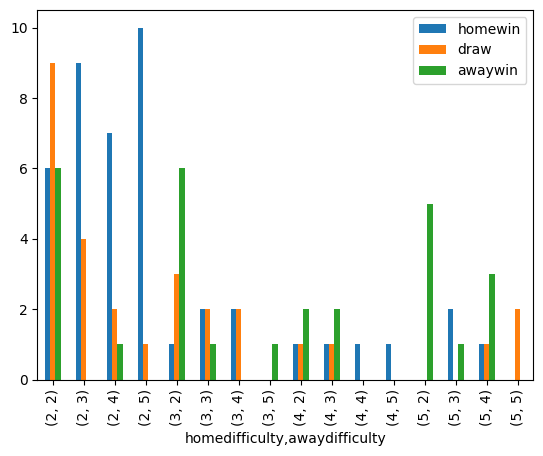

In [140]:
fixture_df.groupby(["homedifficulty", "awaydifficulty"]).aggregate(
    {"homewin": "sum", "draw": "sum", "awaywin": "sum"}
).plot(kind="bar")

In [40]:
full_df.columns

Index(['id', 'minutes', 'goals_scored', 'assists', 'clean_sheets',
       'goals_conceded', 'own_goals', 'penalties_saved', 'penalties_missed',
       'yellow_cards', 'red_cards', 'saves', 'bonus', 'bps', 'influence',
       'creativity', 'threat', 'ict_index', 'starts', 'expected_goals',
       'expected_assists', 'expected_goal_involvements',
       'expected_goals_conceded', 'total_points', 'in_dreamteam', 'team',
       'position'],
      dtype='object')

In [41]:
columns = [
    "influence",
    "creativity",
    "threat",
    "ict_index",
    "expected_goals",
    "expected_assists",
    "expected_goal_involvements",
    "expected_goals_conceded",
]

for col in columns:
    full_df[col] = full_df[col].astype(float)

In [44]:
print("Totals")
for i in full_df.columns:
    print(f"{i}:{full_df[i].sum()}")

Totals
id:1923905
minutes:177213
goals_scored:254
assists:231
clean_sheets:428
goals_conceded:2871
own_goals:7
penalties_saved:4
penalties_missed:4
yellow_cards:466
red_cards:14
saves:607
bonus:567
bps:30424
influence:41362.0
creativity:29179.300000000003
threat:26704.0
ict_index:9718.699999999999
starts:1980
expected_goals:267.86
expected_assists:179.28
expected_goal_involvements:447.10999999999996
expected_goals_conceded:2911.26
total_points:7201
in_dreamteam:99
team:ArsenalArsenalArsenalArsenalArsenalArsenalArsenalArsenalArsenalFulhamCrystal PalaceArsenalArsenalSouthamptonArsenalArsenalArsenalArsenalFulhamArsenalArsenalArsenalArsenalArsenalArsenalNott'm ForestSouthamptonAston VillaAston VillaAston VillaAston VillaAston VillaAston VillaAston VillaAston VillaAston VillaAston VillaAston VillaAston VillaAston VillaAston VillaAston VillaAston VillaAston VillaAston VillaAston VillaAston VillaAston VillaAston VillaAston VillaAston VillaAston VillaAston VillaAston VillaAston VillaAston Vill

TRY GROUPBYs BY TEAMS, BY POSITIONS

In [45]:
pd.set_option("display.max_rows", None)

In [53]:
full_df.groupby(["team", "position"]).aggregate(
    {
        "goals_scored": "sum",
        "total_points": ["sum", "max", "mean"],
        "creativity": ["max"],
    }
)
# .sort_values(by= ("total_points", "max"), ascending=False)

goals_scored total_points               creativity
                                   sum          sum max      mean        max
team           position                                                     
Arsenal        Defender              3          131  15  1.350515       82.8
               Forward               4           48  12  2.285714       31.5
               Goalkeeper            0           44  10  1.294118        0.0
               Midfielder            9          201  16  1.689076      114.3
Aston Villa    Defender              1          108   9  0.939130       54.0
               Forward               9           80  13  4.444444       22.6
               Goalkeeper            0           30   9  0.576923        0.0
               Midfielder            5          165  10  1.170213       62.1
Bournemouth    Defender              0           82   9  1.012346       29.8
               Forward               2           38   9  1.461538       23.9
               Goalkeeper            0           24   6  0.666667        0.0
               Midfielder            9          195  11  1.547619       59.8
Brentford      Defender              3           76  10  0.791667       63.2
               Forward               4           39  11  1.444444       37.1
               Goalkeeper            0           24   4  1.333333        0.1
               Midfielder           10          220  15  1.496599       86.8
Brighton       Defender              0           99   8  1.076087       41.3
               Forward               9           87  12  1.933333       25.2
               Goalkeeper            0           31  10  1.107143        0.0
               Midfielder            7          198  12  0.891892       43.8
Chelsea        Defender              0           75   7  0.694444       23.4
               Forward               6           58  16  1.288889       31.5
               Goalkeeper            0           39  15  0.866667        0.0
               Midfielder           13          240  25  1.490683       69.9
Crystal Palace Defender              1          124   9  1.377778       58.0
               Forward               3           41  13  2.277778       41.7
               Goalkeeper            0           32   9  1.185185        0.0
               Midfielder            1          103  10  0.710345       56.2
Everton        Defender              2           98  14  1.101124       30.1
               Forward               5           71  12  1.314815       47.1
               Goalkeeper            0           33  15  1.269231        0.1
               Midfielder            3          131  15  1.505747       89.1
Fulham         Defender              0           84   8  0.933333       31.4
               Forward               5           61   9  1.694444       37.3
               Goalkeeper            0           28   5  1.555556       10.0
               Midfielder            7          189  11  1.629310       96.3
Ipswich        Defender              0           60   7  0.566038       88.1
               Forward               6           55  12  1.527778       23.6
               Goalkeeper            0           26  11  0.962963        0.0
               Midfielder            3          130   9  1.074380       46.0
Leicester      Defender              3           78  12  0.866667       32.8
               Forward               4           44   8  1.222222       29.6
               Goalkeeper            0           25   6  0.694444        0.1
               Midfielder            6          174  11  1.308271       51.8
Liverpool      Defender              2          176  11  1.955556       62.0
               Forward               1           26   6  1.444444       56.3
               Goalkeeper            0           48  10  2.000000        0.0
               Midfielder           14          267  17  2.007519       68.3
Man City       Defender              4          140  10  1.750000       62.2
               Forward